In [1]:
library(tidyverse)
library(Seurat)
library(ggplot2)
library(patchwork)
library(hdf5r)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘hdf5r’


The following object is masked from ‘package:purrr’:

    flatten_df




# Import Data

In [2]:
# import raw counts from cellranger
dataRaw1 <- Read10X_h5("/data/rudensky/EYW/SIG04_240816/SIG04_lane1_merge_GEX_oBC/outs/filtered_feature_bc_matrix.h5")
dataRaw2 <- Read10X_h5("/data/rudensky/EYW/SIG04_240816/SIG04_lane2_merge_GEX_oBC/outs/filtered_feature_bc_matrix.h5")

# import post-QC anndata metadata
metaLane1 <- read.csv("/data/rudensky/EYW/git_projects/SIG04_240816/processing_outs/postQC_meta_lane1.csv", row.names = "cell_barcode")
metaLane2 <- read.csv("/data/rudensky/EYW/git_projects/SIG04_240816/processing_outs/postQC_meta_lane2.csv", row.names = "cell_barcode")

names(dataRaw1)
names(dataRaw2)

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome



[1] "Gene Expression"      "CRISPR Guide Capture"

[1] "Gene Expression"      "CRISPR Guide Capture"

## Filter for joint cells

In [3]:
subset_joint <- function(x){
  # identify joint cells between BC and GEX dataset
  jointCells <- intersect(colnames(x$`Gene Expression`),
                          colnames(x$`CRISPR Guide Capture`))
  
  # subset each dataset to include joint cells
  data <- vector(mode = "list")
  data[["GEX"]] <- x$`Gene Expression`[,jointCells]
  data[["oBC"]] <- x$`CRISPR Guide Capture`[,jointCells]
  
  return(data)
}

dataRaw1 <- subset_joint(dataRaw1)
dataRaw2 <- subset_joint(dataRaw2)

## Filter for low genes
Remove genes detected in less than 1/1000 cells

In [4]:
dataMergeGEX <- cbind(dataRaw1$GEX,dataRaw2$GEX)

# create vector of genes to keep
keepGenes <- Matrix::rowSums(dataMergeGEX > 0) >= ncol(dataMergeGEX)*(1/1000)

# remove genes from gex matrices
dataRaw1$GEX <- dataRaw1$GEX[keepGenes,]
dataRaw2$GEX <- dataRaw2$GEX[keepGenes,]

rm(dataMergeGEX)

## Create Seurat Object

In [5]:
create_seurat <- function(x){
  # load GEX counts and add celltag counts into seurat object
  data <- CreateSeuratObject(counts = x$GEX, project = "SIG04")
  data[["oBC"]] <- CreateAssayObject(counts = x$oBC)

  return(data)
}

dataSeurat <- vector(mode = "list")
dataSeurat[["lane1"]] <- create_seurat(dataRaw1)
dataSeurat[["lane2"]] <- create_seurat(dataRaw2)

rm(dataRaw1,dataRaw2)

## Filter and merge with Anndata Meta

In [6]:
merge_adMeta <- function(seurat,meta){
  seurat <- subset(seurat, cells = rownames(meta))
  # make sure cell barcodes match order between metadata and seurat
  meta <- meta[match(colnames(seurat),rownames(meta)),]
  print(paste0("All cells match?: ",
               sum(rownames(meta) == colnames(seurat)) == ncol(seurat)))
  # replace metadata with anndata meta
  seurat@meta.data <- meta
  
  return(seurat)
}

dataSeurat[["lane1"]] <- merge_adMeta(dataSeurat$lane1, metaLane1)
dataSeurat[["lane2"]] <- merge_adMeta(dataSeurat$lane2, metaLane2)

[1] "All cells match?: TRUE"
[1] "All cells match?: TRUE"


## Merge into same object

In [7]:
data <- merge(dataSeurat[[1]],dataSeurat[[2]],
              add.cell.ids = c("lane1","lane2"), project = "SIG04") %>%
  JoinLayers()

rm(dataSeurat)

# Scale Data

In [8]:
DefaultAssay(data) <- "RNA"
data <- NormalizeData(data, normalization.method = "LogNormalize") %>%
  FindVariableFeatures(selection.method = "vst",
                       nfeatures = 2000, 
                       verbose = FALSE) %>%
  ScaleData
data <- ScaleData(data)

DefaultAssay(data) <- "oBC"
data <- NormalizeData(data, normalization.method = "CLR") %>%
  ScaleData

Normalizing layer: counts

Centering and scaling data matrix

Centering and scaling data matrix

Normalizing across features

Centering and scaling data matrix



# Add CC Scores

In [9]:
DefaultAssay(data) <- "RNA"

cellCycleGenes <- read_csv("/data/rudensky/EYW/git_projects/SIG04_240816/functions/cell_cycle_genes_seurat_mouse.csv")

data <- CellCycleScoring(data, s.features = cellCycleGenes$s_genes,
                            g2m.features = cellCycleGenes$g2m_genes)

Rows: 40 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): s_genes, g2m_genes

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
table(data$Phase)


   G1   G2M     S 
73634 19449 21057 

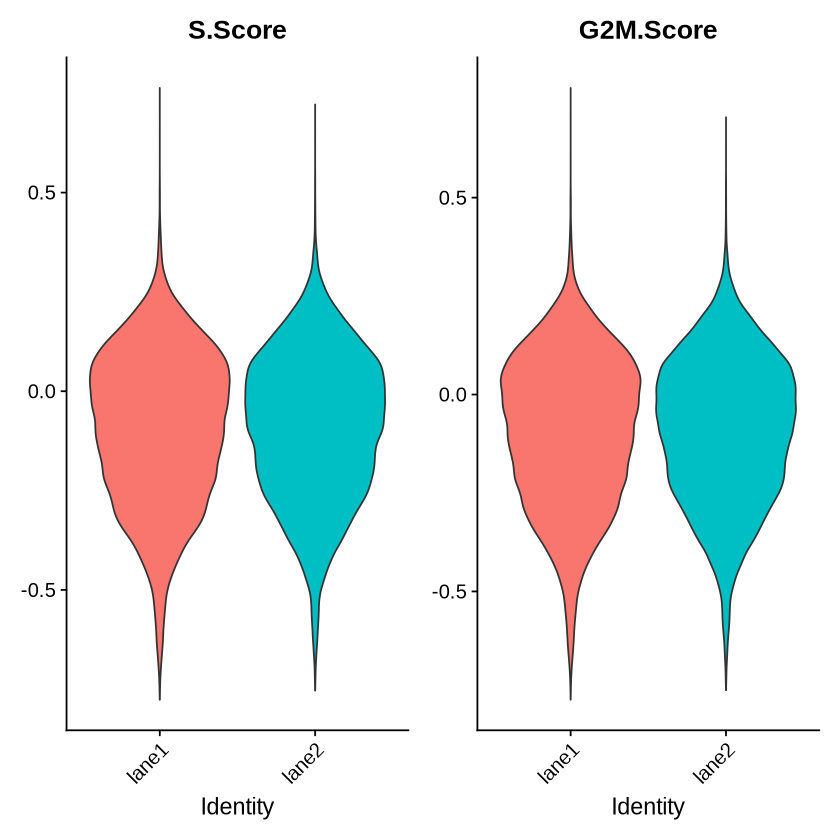

In [16]:
VlnPlot(data, c("S.Score","G2M.Score"), group.by = "gem_group", pt.size=0)

## Export as RDS

In [12]:
saveRDS(data, "/data/rudensky/EYW/SIG04_240816/seurat_outs/SIG04_postqc_seurat.rds")